# Simulation-based model interpretation with gReLU

This tutorial demonstrates some of gReLU's functions for making predictions on simulated genomic sequences with specific properties. This allows us to decipher the regulatory grammar and syntax learned by a model.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats

from plotnine import *
import seaborn as sns

%matplotlib inline
os.environ["WANDB_SILENT"] = "true"

First we demonstrate some simple functions using the CATLAS binary classification model. We begin by loading the model from the model zoo:

In [2]:
import grelu.resources

catlas = grelu.resources.load_model(
    project="human-atac-catlas",
    model_name="model",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
/opt/conda/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wher

Note once again that this object contains the model metadata, so we can extract a dataframe describing the cell types for which the model makes predictions.

In [3]:
tasks = pd.DataFrame(catlas.data_params['tasks'])
print(len(tasks))
tasks.head(3)

204


,name,cell type
0,Follicular,Follicular
1,Fibro General,Fibro General
2,Acinar,Acinar


We can also extract genomic intervals that were in the test set of this model:

In [4]:
test_intervals = pd.DataFrame(catlas.data_params['test']['intervals'])

In [5]:
test_intervals.head()

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module,width,cre_idx,enformer_split,split
0,chr1,143497510,143497710,Promoter Proximal,no,yes,113,400,53530,test,test
1,chr1,143498052,143498252,Promoter Proximal,no,yes,4,400,53531,test,test
2,chr1,143498633,143498833,Promoter,yes,no,46,400,53532,test,test
3,chr1,143563536,143563736,Distal,yes,no,63,400,53533,test,test
4,chr1,143575231,143575431,Distal,no,yes,28,400,53534,test,test


Let us extract 100 intervals from the test set:

In [6]:
test_intervals = test_intervals.sample(100, random_state=0)

### Motif marginalization

In order to understand the function of a specific motif, we can insert the motif into shuffled sequences. By making predictions on the shuffled sequences before and after motif insertion, we can compute the extent to which the motif alone increases predicted activity.

To demonstrate, we extract a few selected motifs from the HOCOMOCO database.

In [7]:
import grelu.io.motifs
import grelu.interpret.motifs

motif_names = ['CTCF.H12CORE.0.P.B', 'IRF4.H12CORE.0.P.B', 'SPI1.H12CORE.0.P.B',
               'HNF1A.H12CORE.0.PS.A']
motifs = grelu.io.motifs.read_meme_file("hocomoco_v12", names=motif_names)

This is a dictionary containing the motifs. We can extract the consensus sequence for each motif:

In [8]:
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)
print(patterns)

['TGGCCACTAGGGGGCGCTAG', 'AAAGAGGAACTGAAACT', 'AAAAGAGGAAGTGA', 'GGTTAATGATTAACC']


Now, we insert each of these motifs into shuffled sequences and compare the predictions before and after motif insertion. gReLU provides an easy function `marginalize_patterns` to perform this analysis.

In [9]:
import grelu.interpret.simulate

preds = grelu.interpret.simulate.marginalize_patterns(
    model=catlas,
    patterns=patterns,
    seqs=test_intervals,
    genome='hg38',
    devices=0,
    num_workers=16,
    batch_size=512,
    n_shuffles=3, # Each test sequence will be shuffled 3 times 
    seed=0,
    compare_func='subtract', # Return the difference in prediction with and without each motif. If not supplied, predictions with and without are returned separately.
).squeeze()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


In [10]:
preds.shape

(100, 3, 4, 204)

The `preds` object has the shape (100, 3, 4, 204) where 100 is the number of background sequences, 4 is the number of motifs, and 204 is the number of cell types.

We can reshape this so we have 300 background sequences for each motif.

In [11]:
preds = preds.reshape(300, 4, 204)

We can now subset the results for our cell type of interest. For example, microglia:

In [12]:
microglia_preds = preds[:, :, tasks.name=='Microglia']
microglia_preds.shape

(300, 4, 1)

In [13]:
microglia_preds = pd.DataFrame(microglia_preds.squeeze(), columns=motif_names)
microglia_preds.head()

,CTCF.H12CORE.0.P.B,IRF4.H12CORE.0.P.B,SPI1.H12CORE.0.P.B,HNF1A.H12CORE.0.PS.A
0,0.028903,0.602199,0.533135,-0.021193
1,0.014234,0.054343,0.016284,-0.002339
2,0.047415,0.107500,0.008276,-0.001469
3,0.015104,0.175864,0.167947,-0.013539
4,-0.053547,0.719626,0.607563,-0.095212


We can now visualize the effect of each of these motifs in microglia:

<Axes: title={'center': 'Increase in predicted probability of\naccessibility in microglia after inserting motif'}>

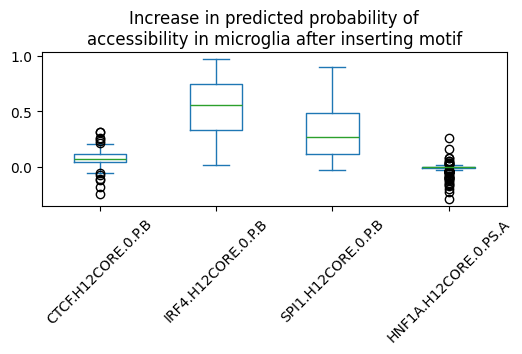

In [14]:
microglia_preds.plot.box(rot=45, figsize=(6,2),
    title='Increase in predicted probability of\naccessibility in microglia after inserting motif')

We can compute the significance of the observed changes using Wilcoxon's signed-rank test:

In [15]:
scipy.stats.wilcoxon(microglia_preds['SPI1.H12CORE.0.P.B'], alternative='greater')

WilcoxonResult(statistic=45138.0, pvalue=3.4306111433259653e-51)

We can also compare the average effect of each motifs across all 204 cell types. For this, we first average the effect across all 500 peaks:

In [16]:
print(preds.shape)
mean_motif_effect = preds.mean(0)
print(mean_motif_effect.shape)

(300, 4, 204)
(4, 204)


This gives us an array of size (motifs x cell types). We can represent this as a pandas dataframe:

In [17]:
mean_motif_effect = pd.DataFrame(mean_motif_effect, index=motif_names, columns=tasks.name)
mean_motif_effect.iloc[:2, :5]

name,Follicular,Fibro General,Acinar,T Lymphocyte 1 (CD8+),T lymphocyte 2 (CD4+)
CTCF.H12CORE.0.P.B,0.388244,0.394328,0.432499,0.305751,0.294902
IRF4.H12CORE.0.P.B,-0.036342,-0.012818,0.002286,0.056316,0.036183


For visualization, let us select the 20 cell types with highest variance:

In [18]:
variable_cell_types = mean_motif_effect.var(0).sort_values().tail(20).index
variable_cell_types

Index(['Fetal Photoreceptor', 'Fetal T Lymphocyte 1 (CD4+)',
       'Fetal Enterocyte 3', 'Fetal Enterocyte 1',
       'Fetal Retinal Progenitor 1', 'Memory B', 'Fetal Acinar 2',
       'Macrophage Gen or Alv', 'Hepatocyte', 'Plasma B',
       'Fetal Adrenal Neuron', 'Alpha 1', 'Fetal Adrenal Cortical', 'Acinar',
       'Fetal Thymocyte', 'Macrophage General',
       'Fetal Syncitio+Cytotrophoblast', 'Fetal B Lymphocyte 1 (SPIB+)',
       'Fetal Erythroblast 2', 'Fetal Hepatoblast'],
      dtype='object', name='name')

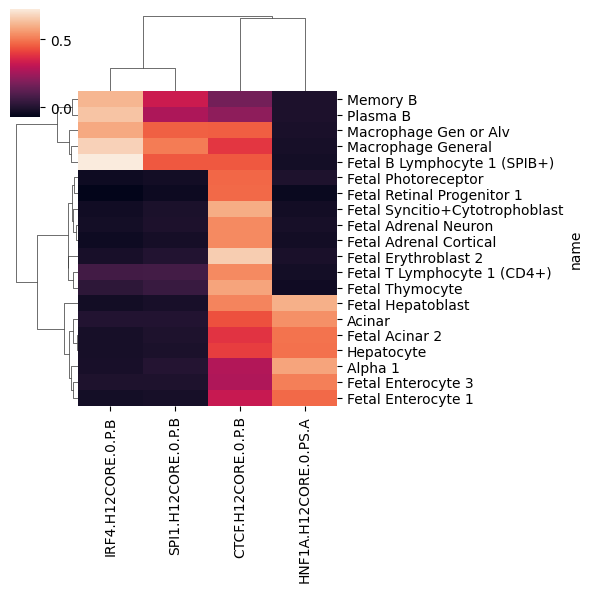

In [19]:
sns.clustermap(mean_motif_effect.loc[:, variable_cell_types].T, figsize=(6,6))